# Implementación del PRM (Probabilistic Roadmap)

Propuesto por Kavraki y otros [1], el PRM (del inglés Probabilistic Roadmap) es un algoritmo de planificación basado en muestreo. Éste basa su funcionamiento en construir un grafo de caminos en el espacio libre y despúes utilizar este mismo grafo para encontrar las rutas.

En este programa se implementan las dos etapas del PRM, la construcción y la consulta, para la cual se usa la heurística A*.

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data for you and provide a template for visualization.

[1] Kavraki, L. E., Svestka, P., Latombe, J. C., & Overmars, M. H. (1996). Probabilistic roadmaps for path planning in high-dimensional configuration spaces. IEEE transactions on Robotics and Automation, 12(4), 566-580.

In [1]:
# Verificar que tengamos networkx
# import sys
#!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
#pkg_resources.require("networkx==2.1")
import networkx as nx

#!pip install sklearn

In [2]:
nx.__version__ # should be 2.1

'2.1'

In [23]:
# Importar paquetes
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
from sklearn.neighbors import KDTree
import time
# funciones previamente programadas
import muestreo 

%matplotlib inline
plt.rcParams['figure.figsize'] = 14, 14

In [5]:
# Cargamos los datos utilizados en el programa anterior.
filename = 'data_reduced.csv'
data = np.loadtxt(filename, delimiter=',', dtype='float64', skiprows=2)

## Construcción
### Muestreo aleatorio

You may want to limit the z-axis values.

In [10]:
def collides(polygons, tree, point):   
    # TODO: Determine whether the point collides
    # with any obstacles.
    collide = False
    x,y,z = point
    p = Point(x, y)
    
    #find the nearest polygon center
    p_array = np.array([x,y])
    idx = tree.query([p_array], k=1, return_distance = False)[0]
    
    poly = polygons[int(idx)]
    polygon, height = poly
    if polygon.contains(p):
        if z < height:
            collide = True
            
    return collide

In [12]:
# Se utilizan las funciones de muestreo ya programadas
samples = muestreo.get_samples(data)
print(samples[:5])

# Create the centers of the polygons
polygons, centers = muestreo.extract_polygons_and_centers(data)
print(centers[:10])



X
min = -295.2389, max = 304.7612

Y
min = -104.23155, max = 401.658113

Z
min = 0, max = 10
[(138.0040280811093, 130.98077208423615, 4.615767741484492), (-44.63183715487364, -13.589150468659625, 3.4969607900763897), (256.8535079091186, -39.02338570807456, 0.13182380428744644), (49.49708098539321, 366.80763913270846, 9.692849191006651), (-149.98330632882406, -63.60450297425274, 6.183130190033844)]
[[-270.2389   -99.23154]
 [-260.2389   -99.23153]
 [-250.2389   -99.23155]
 [-240.2389   -99.23154]
 [-230.2389   -99.23154]
 [-190.2389   -99.23154]
 [-180.2389   -99.23154]
 [-170.2389   -99.23154]
 [-160.2389   -99.23154]
 [-150.2389   -99.23154]]


In [13]:
# then use KDTree to find nearest neighbor polygon and test for collision
# Tip: use un KDTree
tree = KDTree(centers)

In [15]:
# Mantener solo las muestras que no están en colisión
t0 = time.time()
to_keep = []
for point in samples:
    # Verificamos colisión
    if not collides(polygons, tree, point):
        to_keep.append(point)
time_taken = time.time() - t0
print("Time taken {0} seconds ...", time_taken)

Time taken {0} seconds ... 0.06731081008911133


In [17]:
print(len(to_keep), "muestras libres de colisión")

623 muestras libres de colisión


### Conexión de nodos

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

**Suggested method**

1. Cast nodes into a graph called "g" using networkx
2. Write a method "can_connect()" that:
    1. casts two points as a shapely LineString() object
    2. tests for collision with a shapely Polygon() object
    3. returns True if connection is possible, False otherwise
3. write a method "create_graph()" that:
    1. defines a networkx graph as g = Graph()
    2. defines a tree = KDTree(nodes)
    3. test for connectivity between each node and 
    4. of it's nearest neighbors
    5. if nodes are connectable, add an edge to graph
    6. Iterate through all candidate nodes!

In [18]:
def can_connect(p1, p2, obstacles):
    x1,y1,z1 = p1
    x2,y2,z2 = p2
    
    line = LineString([(x1, y1), (x2, y2)])
    free = True
    
    for obst in obstacles:
        poly, height = obst
        if line.crosses(poly):
            free = False
    
    return free

In [19]:
def create_graph(milestones, polygons, k):
    array_milestones = np.array(milestones)
    #print(array_milestones[:10])
    m_tree = KDTree(array_milestones)
    g = nx.Graph()
    
    for mil in milestones:
        #print(mil)
        
        mil_array = np.array(mil)
        #print(mil_array)
        # find the nearest k milestones
        distances, indexes = m_tree.query([mil_array], k)

        #print(dist)
        #print(idx)
        for dist, idx in zip(distances[0], indexes[0]):
            #print(dist)
            #print(idx)
            if dist > 0:
                if can_connect(mil, milestones[int(idx)], polygons):
                    g.add_edge(mil, milestones[int(idx)], weight=dist)
        
    return g

In [20]:
# TODO: create the graph
k = 6
g = create_graph(to_keep, polygons, k)

### Visualización

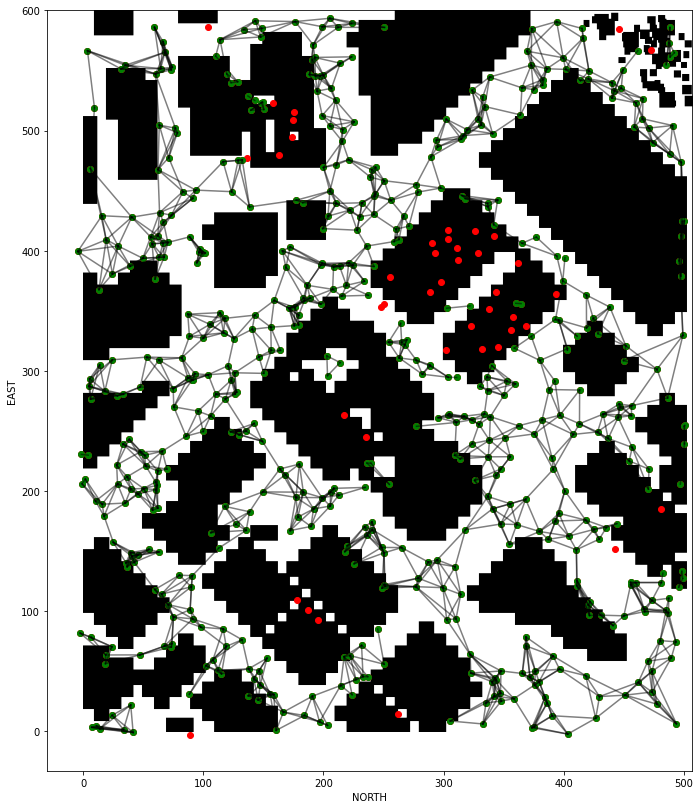

In [24]:
# Create a grid map of the world
from grid import create_grid
# This will create a grid map at 1 m above ground level
grid = create_grid(data, 1, 1)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# Draw all nodes connected or not in blue
for n1 in to_keep:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='green')
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

## Consulta de ruta

### Implementación de A*

Deinición de la heuristica

In [25]:
import numpy.linalg as LA

def heuristic(n1, n2):
    # TODO: finish
    return LA.norm(np.array(n2) - np.array(n1))

Algoritmo de búsqueda

In [26]:
def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    # TODO: complete

    path = []
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (new_cost, current_node)
             
    path = []
    path_cost = 0
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    return path[::-1], path_cost


In [27]:
start = list(g.nodes)[0]
k = np.random.randint(len(g.nodes))
print(k, len(g.nodes))
goal = list(g.nodes)[k]
print('start', start)
print('goal', goal)

path, cost = a_star(g, heuristic, start, goal)
print(len(path), path)

path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    print(n1, n2)

155 580
start (138.0040280811093, 130.98077208423615, 4.615767741484492)
goal (207.2011067353772, 241.4945343086495, 0.9080235458253461)
Found a path.
7 [(138.0040280811093, 130.98077208423615, 4.615767741484492), (155.18275917764208, 143.14037867714296, 6.010375954500149), (167.99314779548843, 151.22246567904412, 1.6959201418377745), (164.7956656163284, 177.95118222716863, 2.0833030606747096), (187.88335899369417, 190.10764180964483, 5.172920142685501), (202.64899751443232, 215.48915901713949, 8.622315141951738), (205.53082506589334, 217.10860940661516, 5.526592714709869)]
(138.0040280811093, 130.98077208423615, 4.615767741484492) (155.18275917764208, 143.14037867714296, 6.010375954500149)
(155.18275917764208, 143.14037867714296, 6.010375954500149) (167.99314779548843, 151.22246567904412, 1.6959201418377745)
(167.99314779548843, 151.22246567904412, 1.6959201418377745) (164.7956656163284, 177.95118222716863, 2.0833030606747096)
(164.7956656163284, 177.95118222716863, 2.0833030606747096

# Prueba y visualización

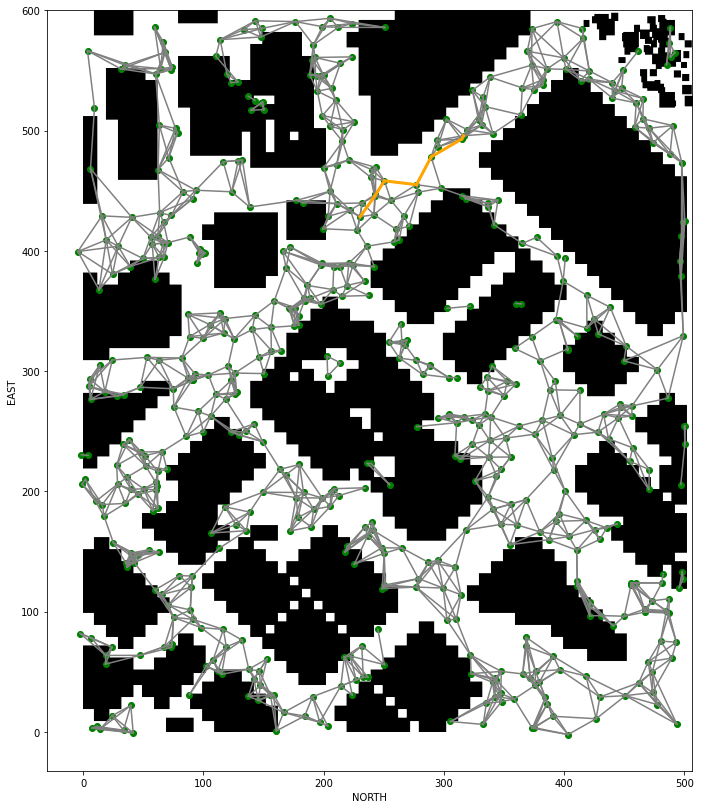

In [28]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])
   
# draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='green')
    
# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'grey')
    
# TODO: add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'orange', linewidth=3)
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()